## 1. Install Dependencies

In [ ]:
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# Install Wandb for monitoring
!pip install wandb
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/17x7am_JGRXfiwNO68mv3yOCpbLK-7IDA/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=17x7am_JGRXfiwNO68mv3yOCpbLK-7IDA
From (redirected): https://drive.google.com/uc?id=17x7am_JGRXfiwNO68mv3yOCpbLK-7IDA&confirm=t&uuid=0b8cae49-bd31-4fe1-adec-c220c65c2843
To: /content/train.csv
100% 185M/185M [00:04<00:00, 41.9MB/s]


## Add HuggingFace's API token

1. Get HuggingFace's API at: https://huggingface.co/settings/profile
2. Store it at Colab's Secret:
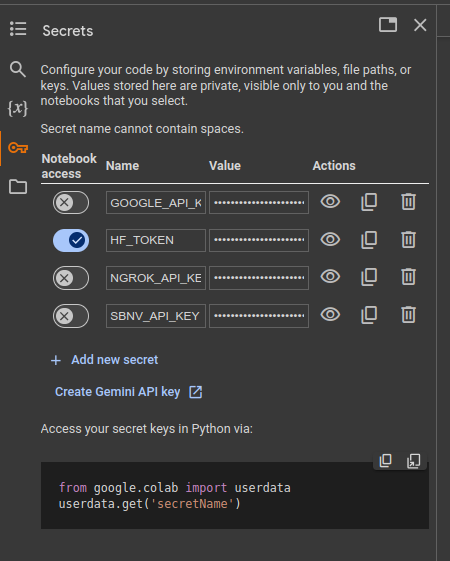

In [ ]:
# Huggingface'token with write permission
# Go to: https://huggingface.co/settings/tokens
# Then create a token with write permission
from google.colab import userdata

HUGGINGFACE_TOKEN = userdata.get('HF_TOKEN')

In [ ]:
# Login to Hugging Face
from huggingface_hub import login
login(token = HUGGINGFACE_TOKEN)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.10.6: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

Unsloth: We fixed a gradient accumulation bug, but it seems like you don't have the latest transformers version!
Please update transformers, TRL and unsloth via:
`pip install --upgrade --no-cache-dir unsloth git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git`


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.10.6 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


## 2. Data preparation

In [ ]:
import pandas as pd

from tqdm import tqdm
from pathlib import Path


def preprocess_row_data(row: pd.Series) -> list[dict]:
    """
    Preprocess row data from BKAI
    """
    result: list[dict] = []
    question = row["question"].replace('"', "").replace("'", "").strip("\n").strip()
    qid = row["qid"]

    cid = [int(x) for x in row["cid"].strip("[] ").split(" ") if x]
    context = row["context"].strip("[]").split("'\n")

    assert len(cid) == len(context), f"{len(cid)} != {len(context)} for {row}"
    for i in range(len(cid)):
        result.append(
            {
                "question": question,
                "context": context[i]
                .replace('"', "")
                .replace("'", "")
                .strip("\n")
                .strip(),
                "cid": cid[i],
                "qid": qid,
            }
        )

    return result


df = pd.read_csv("train.csv")
columns = df.columns

all_rows = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    all_rows.extend(preprocess_row_data(row))

processed_df = pd.DataFrame(all_rows)

processed_df.to_csv("preprocessed_train.csv", index=False)


100%|██████████| 119456/119456 [00:08<00:00, 14076.87it/s]


In [ ]:
def preprocess_row_data(row: pd.Series) -> list[dict]:
    """
    Preprocess row data from BKAI to FineTome 100k format
    """
    result: list[tuple[dict, dict]] = []
    question = row["question"]

    context = row["context"]

    result.append(
        [
            {
                "from": "human",
                "value": question,
            },
            {
                "from": "gpt",
                "value": context,
            }
        ]
    )

    return result

def convert_data_to_FineTome_100k_format(
    train_file: str | Path, progess: bool = True
) -> list[dict]:
    """
    Convert BKAI data to FineTome 100k format
    """
    assert Path(train_file).suffix == ".csv", "Only csv files are supported"

    conversations_list: list[dict] = []
    df = pd.read_csv(train_file)

    iterrows = tqdm(df.iterrows(), total=len(df)) if progess else df.iterrows()
    for _, row in iterrows:
        conversations_list.extend(preprocess_row_data(row))

    return conversations_list



In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

In [ ]:
import datasets
from unsloth.chat_templates import standardize_sharegpt, get_chat_template

def load_dataset(
    train_file: str | Path, tokenizer: any, progress: bool = False
) -> datasets.Dataset:
    """
    Load dataset from csv file
    """
    assert Path(train_file).suffix == ".csv", "Only csv files are supported"
    conversations_list = convert_data_to_FineTome_100k_format(
        train_file, progess=progress
    )

    dataset = datasets.Dataset.from_dict({"conversations": conversations_list})

    tokenizer = get_chat_template(tokenizer, chat_template="llama-3.1")

    def formatting_prompts_func(examples):
        convos = examples["conversations"]
        texts = [
            tokenizer.apply_chat_template(
                convo, tokenize=False, add_generation_prompt=False
            )
            for convo in convos
        ]
        return {
            "text": texts,
        }

    dataset = standardize_sharegpt(dataset)
    dataset = dataset.map(
        formatting_prompts_func,
        batched=True,
    )

    return dataset

In [ ]:
dataset = load_dataset("./preprocessed_train.csv", tokenizer, progress=True)

100%|██████████| 133568/133568 [00:07<00:00, 16837.28it/s]


Standardizing format:   0%|          | 0/133568 [00:00<?, ? examples/s]

Map:   0%|          | 0/133568 [00:00<?, ? examples/s]

We look at how the conversations are structured for item 5:

In [ ]:
dataset[5]["conversations"]

[{'content': 'Chi phí hoạt động dịch vụ của Ngân hàng Hợp tác xã Việt Nam bao gồm những khoản chi nào?',
  'role': 'user'},
 {'content': 'Chi phí\\nChi phí của Ngân hàng bao gồm các khoản chi quy định tại Điều 17 Nghị định số 93/2017/NĐ-CP. Cụ thể:\\n1. Chi phí lãi và các chi phí tương tự:\\na) Chi trả lãi tiền gửi: Chi trả lãi tiền gửi của các quỹ tín dụng nhân dân thành viên; Chi trả lãi tiền gửi của các khách hàng không phải là quỹ tín dụng nhân dân thành viên.\\nb) Chi trả lãi tiền vay.\\nc) Chi trả lãi phát hành giấy tờ có giá.\\nd) Chi khác cho hoạt động tín dụng.\\n2. Chi phí hoạt động dịch vụ:\\na) Chi về dịch vụ thanh toán.\\nb) Chi về dịch vụ ngân quỹ.\\nc) Chi về dịch vụ viễn thông.\\nd) Chi về nghiệp vụ ủy thác và đại lý.\\nđ) Chi về dịch vụ tư vấn.\\ne) Chi hoa hồng cho đại lý, môi giới, ủy thác đối với các hoạt động đại lý, môi giới, ủy thác được pháp luật cho phép. Trong đó đối với chi hoa hồng môi giới thực hiện theo quy định sau:\\n- Ngân hàng được chi hoa hồng môi giớ

In [ ]:
dataset[5]["text"]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nChi phí hoạt động dịch vụ của Ngân hàng Hợp tác xã Việt Nam bao gồm những khoản chi nào?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nChi phí\\nChi phí của Ngân hàng bao gồm các khoản chi quy định tại Điều 17 Nghị định số 93/2017/NĐ-CP. Cụ thể:\\n1. Chi phí lãi và các chi phí tương tự:\\na) Chi trả lãi tiền gửi: Chi trả lãi tiền gửi của các quỹ tín dụng nhân dân thành viên; Chi trả lãi tiền gửi của các khách hàng không phải là quỹ tín dụng nhân dân thành viên.\\nb) Chi trả lãi tiền vay.\\nc) Chi trả lãi phát hành giấy tờ có giá.\\nd) Chi khác cho hoạt động tín dụng.\\n2. Chi phí hoạt động dịch vụ:\\na) Chi về dịch vụ thanh toán.\\nb) Chi về dịch vụ ngân quỹ.\\nc) Chi về dịch vụ viễn thông.\\nd) Chi về nghiệp vụ ủy thác và đại lý.\\nđ) Chi về dịch vụ tư vấn.\\ne) Chi hoa hồng cho đại lý, môi 

## 3. Train the model

Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
output_dir = "models"

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = output_dir,
        report_to="none"
    ),
)

Map (num_proc=2):   0%|          | 0/133568 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/133568 [00:00<?, ? examples/s]

We verify masking is actually done:

In [ ]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nChi phí hoạt động dịch vụ của Ngân hàng Hợp tác xã Việt Nam bao gồm những khoản chi nào?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nChi phí\\nChi phí của Ngân hàng bao gồm các khoản chi quy định tại Điều 17 Nghị định số 93/2017/NĐ-CP. Cụ thể:\\n1. Chi phí lãi và các chi phí tương tự:\\na) Chi trả lãi tiền gửi: Chi trả lãi tiền gửi của các quỹ tín dụng nhân dân thành viên; Chi trả lãi tiền gửi của các khách hàng không phải là quỹ tín dụng nhân dân thành viên.\\nb) Chi trả lãi tiền vay.\\nc) Chi trả lãi phát hành giấy tờ có giá.\\nd) Chi khác cho hoạt động tín dụng.\\n2. Chi phí hoạt động dịch vụ:\\na) Chi về dịch vụ thanh toán.\\nb) Chi về dịch vụ ngân quỹ.\\nc) Chi về dịch vụ viễn thông.\\nd) Chi về nghiệp vụ ủy thác và đại lý.\\nđ) Chi về dịch vụ tư vấn.\\ne) Chi hoa hồng cho đại lý, môi 

In [ ]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                         \n\nChi phí\\nChi phí của Ngân hàng bao gồm các khoản chi quy định tại Điều 17 Nghị định số 93/2017/NĐ-CP. Cụ thể:\\n1. Chi phí lãi và các chi phí tương tự:\\na) Chi trả lãi tiền gửi: Chi trả lãi tiền gửi của các quỹ tín dụng nhân dân thành viên; Chi trả lãi tiền gửi của các khách hàng không phải là quỹ tín dụng nhân dân thành viên.\\nb) Chi trả lãi tiền vay.\\nc) Chi trả lãi phát hành giấy tờ có giá.\\nd) Chi khác cho hoạt động tín dụng.\\n2. Chi phí hoạt động dịch vụ:\\na) Chi về dịch vụ thanh toán.\\nb) Chi về dịch vụ ngân quỹ.\\nc) Chi về dịch vụ viễn thông.\\nd) Chi về nghiệp vụ ủy thác và đại lý.\\nđ) Chi về dịch vụ tư vấn.\\ne) Chi hoa hồng cho đại lý, môi giới, ủy thác đối với các hoạt động đại lý, môi giới, ủy thác được pháp luật cho phép. Trong đó đối với chi hoa hồng môi giới thực hiện theo quy định sau:\\n- Ngân hàng được chi hoa hồng môi giới đối với hoạt động môi giới được pháp luật cho phép.\\n...<|eot_id|>'

We can see the System and Instruction prompts are successfully masked!

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
1.191 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 133,568 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 60
 "-____-"     Number of trainable parameters = 22,544,384


**** Unsloth: Please use our fixed gradient_accumulation_steps by updating transformers, TRL and Unsloth!
`pip install --upgrade --no-cache-dir unsloth git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git`


Step,Training Loss
1,2.064500
2,2.013100
3,2.018400
4,1.991700
5,1.861200
6,2.066700
7,1.875700
8,2.047600
9,1.804500
10,1.981900


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

251.0644 seconds used for training.
4.18 minutes used for training.
Peak reserved memory = 6.721 GB.
Peak reserved memory for training = 5.53 GB.
Peak reserved memory % of max memory = 45.572 %.
Peak reserved memory for training % of max memory = 37.497 %.


## 4. Inference

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Người học ngành quản lý khai thác công trình thủy lợi trình độ cao đẳng phải có khả năng học tập và nâng cao trình độ như thế nào?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 256, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nNgười học ngành quản lý khai thác công trình thủy lợi trình độ cao đẳng phải có khả năng học tập và nâng cao trình độ như thế nào?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nNăng lực cần đạt được trong việc học tập\\n- Luyện tập hiệu quả theo kế hoạch giáo dục tại các khu vực học tập.\\n- Sử dụng tốt các công cụ học tập: máy tính, thiết bị điện tử, tài liệu cơ bản, sách giáo dục; tích cực tham gia hoạt động dạy học ở khu vực học tập của mình.\\n- Có đủ năng lực và kinh nghiệm về giáo dục:\\n1. Lập chương trình giảng dạy và điều chỉnh theo từng học kỳ.\\n2. Đơn giản hóa chương trình giáo dục.\\n3. Có phương pháp giảng dạy, học tập và chuẩn bị cho học tập của mình và các học sinh.\\n4. Hiệu chỉnh, sửa đổi sách giáo khoa cho các lớp học thuộc chương trình, chủ đề giáo dục và sách giáo khoa t

## 5. Save the model

To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
from huggingface_hub import login, create_repo, upload_folder

login(token=HUGGINGFACE_TOKEN)

# Add your model name here hf_username/model_name
hf_model_name = "StoicCodingLab/test_model"

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.save_pretrained_gguf(
    output_dir,
    tokenizer,
    quantization_method=[
        "q4_k_m",
        "q8_0",
        "q5_k_m",
    ],
)

create_repo(hf_model_name, repo_type="model")

upload_folder(
    folder_path=output_dir,
    repo_id=hf_model_name,
    repo_type="model",
    commit_message="Upload model files",
    ignore_patterns=[".git*", "*.ipynb"],
)

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 1.0G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.17 out of 12.67 RAM for saving.


100%|██████████| 16/16 [00:01<00:00, 15.28it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving models/pytorch_model.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp will take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits will take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m', 'q8_0', 'q5_k_m'] will take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: [0] Installing llama.cpp. This will take 3 minutes...
Unsloth: [1] Converting model at models into f16 GGUF format.
The output location will be /content/models/unsloth.F16.gguf
This will take 3 minutes...
INFO:hf-to-gguf:Loading model: models
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {32}
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model.bin'
INFO:hf-to-gguf:token_embd.weight,           torch.float16 --> F16, shape = {2048, 128256}
INFO:hf-to-gguf:blk.0.attn_q.weight,         torch

HfHubHTTPError:  (Request ID: Root=1-671a5c57-0e68381b4f2b195673295c23;ca5bb7a9-8835-43f0-8930-3688ef49520a)

403 Forbidden: You don't have the rights to create a model under the namespace "hienhayho".
Cannot access content at: https://huggingface.co/api/repos/create.
If you are trying to create or update content, make sure you have a token with the `write` role.